In [18]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
from calflops import calculate_flops
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.utils import calc_model_flops, hash_dict
import sqlite3
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import random
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

Files already downloaded and verified


In [20]:
from sophius.estimate import LSTMRegressor

estimator = torch.load('../data/models/estimator_v1.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

In [21]:
def read_model_db(model_id):    
    with sqlite3.connect('../data/models.db') as conn:
        hash_str = conn.execute(f'SELECT hash FROM models WHERE id==?', (model_id, )).fetchone()[0]
    return encoder.hash2model(hash_str, (3, 32, 32), 10)

read_model_db(2604)

Conv2d       (192, 16, 16)  (5, 5)   (2, 2)  
ReLU         (192, 16, 16) 
MaxPool2d    (192, 16, 16)  (3, 3)   (1, 1)  
BatchNorm2d  (192, 16, 16) 
AvgPool2d    (192, 9, 9)    (2, 2)   (2, 2)  
Conv2d       (64, 9, 9)     (3, 3)   (1, 1)  
PReLU        (64, 9, 9)    
BatchNorm2d  (64, 9, 9)    
AvgPool2d    (64, 8, 8)     (2, 2)   (1, 1)  
Conv2d       (192, 2, 2)    (7, 7)   (4, 4)  
ReLU         (192, 2, 2)   
BatchNorm2d  (192, 2, 2)   
PReLU        (192, 2, 2)   
BatchNorm2d  (192, 2, 2)   
GlobalAvgPool2d (192, 1, 1)   
Flatten      192           
Linear       10            

Conv2d       (32, 9, 9)     (2, 2)   (4, 4)  
ReLU         (32, 9, 9)    
AvgPool2d    (32, 10, 10)   (2, 2)   (1, 1)  
GlobalAvgPool2d (32, 1, 1)    
Flatten      32            
Linear       10            



Loss 324.464: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


val_acc: 0.228 train_acc: 0.248
val_acc* 0.282


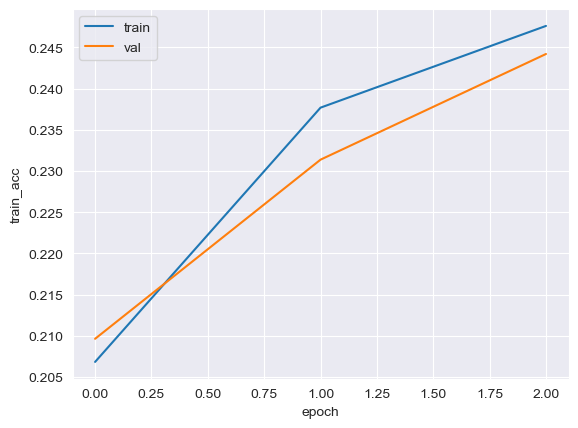

In [22]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=3, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
# model_tmpl = read_model_db(2604)

model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)

print(model_tmpl)

val_acc_threshold = 0.6

train_params = {
    'val_size': 10000,
    'batch_size': 256,
    'num_epoch': 3,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [23]:
import sqlite3
from sophius.utils import hash_dict

exp_id = 0
with sqlite3.connect('../data/models.db') as conn:
    try:
        exp_id = conn.execute('SELECT COUNT(*) FROM test_experiments').fetchone()[0]
    except:
        pass
    exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10}}
    
    df = pd.DataFrame([exp_params], index=[exp_id])
    df.index.name = 'id'
    exp_hash = hash_dict(exp_params)
    df['hash'] = exp_hash
    # cast complex objects to string
    for col in ['opt_params', 'sch_params', 'in_shape', 'out_shape']:
        df[col] = df[col].astype(str)
    
    if exp_id == 0:
        print('Creating new experiment')
        df.to_sql('test_experiments', conn, if_exists='append')
    else:
        # check if experiment exists
        res = conn.execute('SELECT id FROM test_experiments WHERE hash == ?', (exp_hash,)).fetchone()
        if res:
            print('Experiment exists')
            print(exp_params)
            exp_id = res[0]
        else:
            print('Creating new experiment')
            print(exp_params)
            df.to_sql('test_experiments', conn, if_exists='append')    
exp_id

Creating new experiment


0

In [24]:
# run stats - run_id, run params
# run_models run_id -> model_id 
# model stats model_id, hash, flops, batch_size
# model_per_epoch stats model_id, 

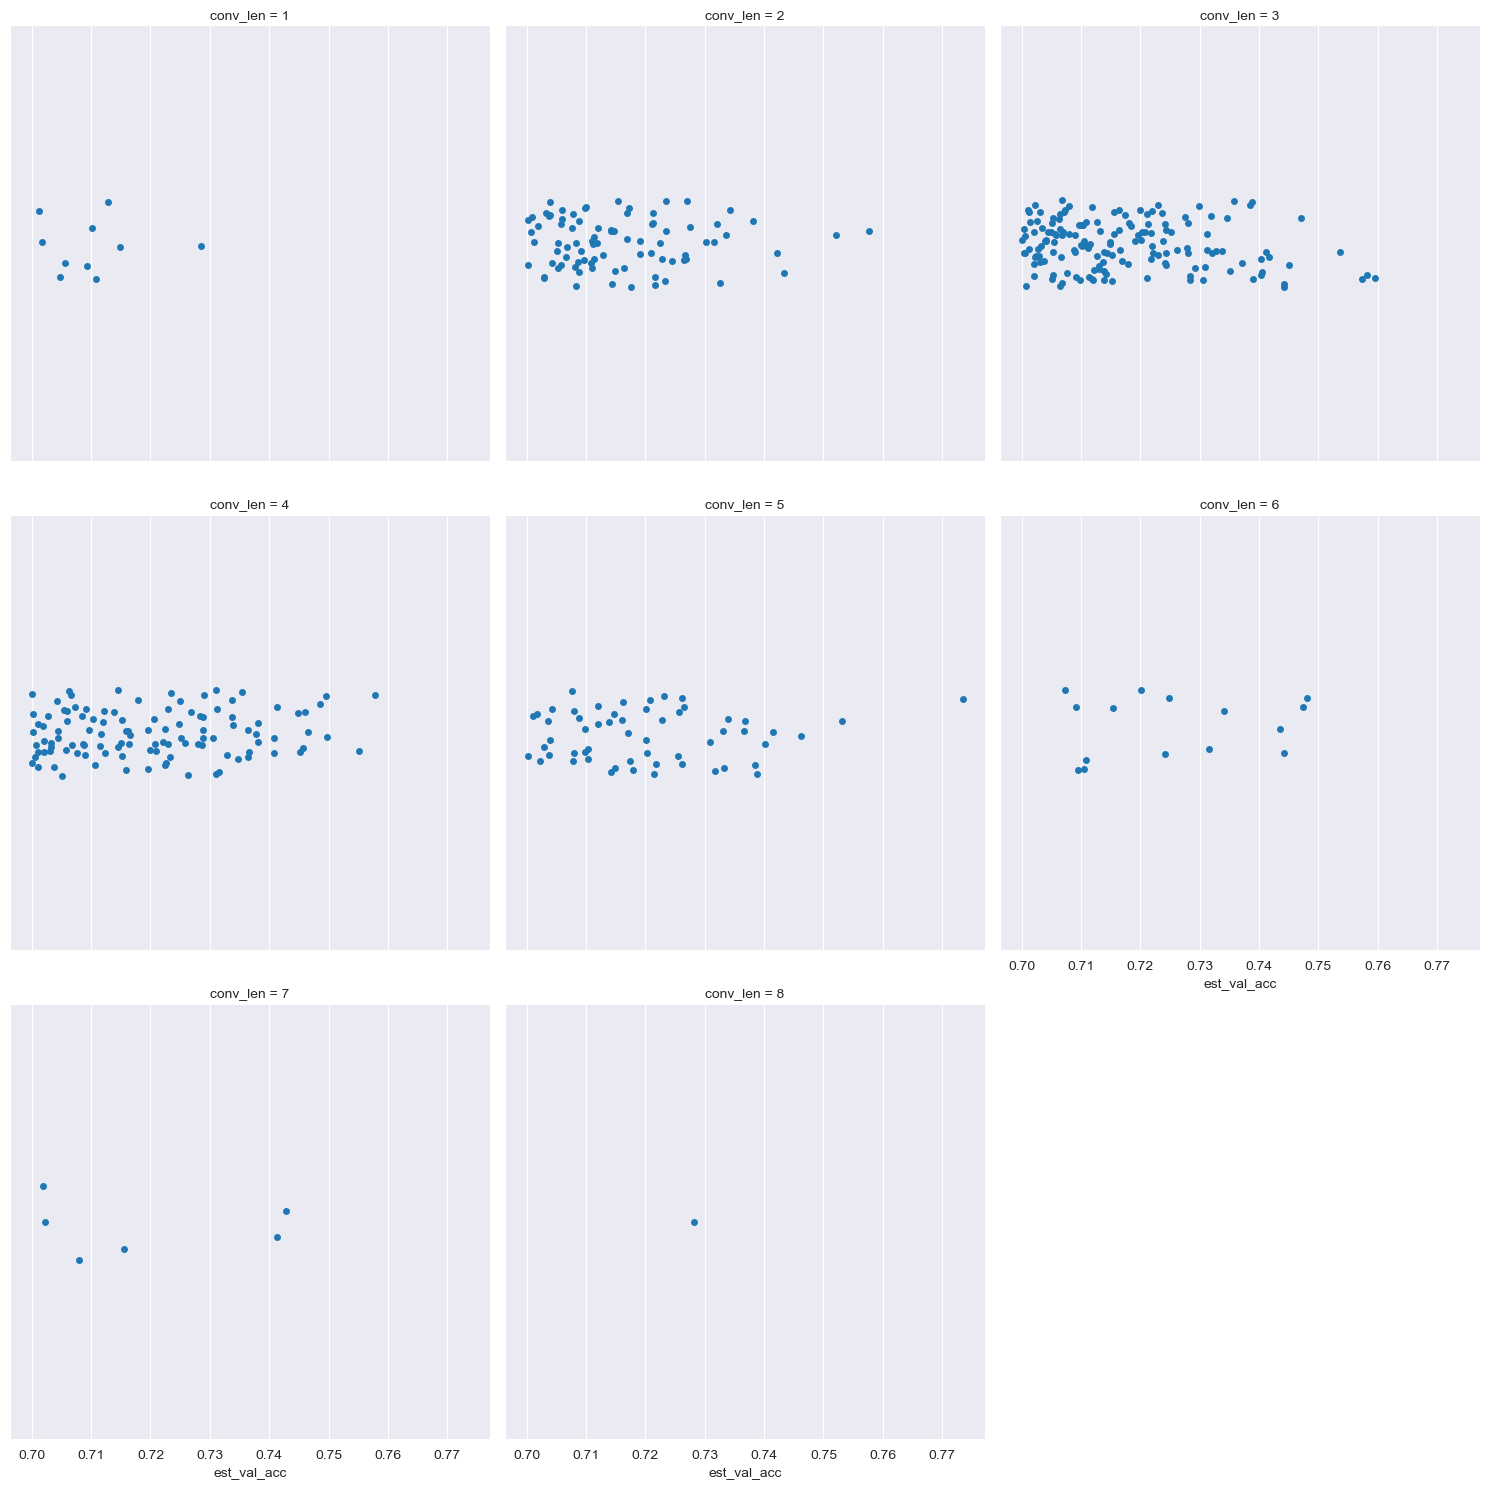

In [47]:
sns.catplot(res, x='est_val_acc', col='conv_len', col_wrap=3);

In [15]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=3, lin_num=1)
estimator = torch.load('../data/models/estimator_v1.pth').cpu()
val_acc_threshold = 0.7

for i in tqdm(range(100)):
    model_tmpl = model_gen.generate_model_tmpl()    
    model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)
    
    est_val_acc = estimate_acc(model_tmpl) 
    if est_val_acc < val_acc_threshold:
        # print('Skip %.3f' % est_val_acc)
        continue
    print('Pass %.3f' % est_val_acc)
    
    epoch_results = train_on_gpu_ex(
        model=model,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    model_id = 0
    with sqlite3.connect('../data/models.db') as conn:
        try:
            model_id = conn.execute('SELECT COUNT(*) FROM test_models').fetchone()[0]
        except:
            pass
        
    model_results = calc_model_flops(model, (3, 32, 32))
    model_results['id'] = model_id
    model_results['exp_id'] = exp_id
    model_results['hash'] = encoder.model2hash(model_tmpl)    
    model_results['val_acc'] = epoch_results.val_acc.iloc[-10:].mean()
    model_results['train_acc'] = epoch_results.train_acc.iloc[-10:].mean()
    model_results['time'] = epoch_results.time.iloc[-1]
    
    epoch_results['model_id'] = model_id
    epoch_results['exp_id'] = exp_id

    with sqlite3.connect('../data/models.db') as conn:
        df = pd.DataFrame([model_results]).set_index('id') 
        df.to_sql('test_models', conn, if_exists='append')
        
        epoch_results.to_sql('test_model_epochs', conn, if_exists='append', index=False)
        
#     # print(df.loc[i])

 48%|████▊     | 48/100 [00:00<00:00, 200.42it/s]

Pass 0.737
Pass 0.703
Pass 0.718
Pass 0.738
Pass 0.726
Pass 0.794


100%|██████████| 100/100 [00:00<00:00, 197.79it/s]

Pass 0.710
